# Лабораториска вежба 2 – – Модели базирани на архитектурата Transformer и промптинг техники
# Dataset: Yelp
# Цел: Класификација на Yelp рецензии (позитивни/негативни) користејќи Transformer модели (RoBERTa, DistilBERT) и промптинг техники; евалуација со accuracy, precision, recall, F1 и анализа на хиперпараметри (learning rate, epochs).
#
#Да се применат T5 и BART со zero-shot и few-shot prompting без дополнително тренирање, да се евалуираат со истите метрики и да се направи квантитативна и квалитативна споредба (перформанси, ресурси, време, ограничувања). Споредба со резултатите од Лаб. 1.


#Задача 1

In [7]:
from google.colab import files
uploaded = files.upload()


Saving val_en.txt to val_en.txt
Saving train_en.txt to train_en.txt
Saving test_en.txt to test_en.txt


In [4]:
import os

from transformers import AutoTokenizer,BertModel, BertForSequenceClassification, BertTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer


In [5]:
import torch
import numpy as np
import pandas as pd
from torch.utils.data import Dataset
from sklearn.model_selection import train_test_split


In [9]:
train_df = pd.read_csv("train_en.txt", sep="\t")
val_df = pd.read_csv("val_en.txt", sep='\t')
test_df = pd.read_csv("test_en.txt", sep='\t')

train_df


,Sentence,Style,User
0,Cute interior and owner (?) gave us tour of up...,positive,bcjbaE6dDog4jkNY91ncLQ
1,I've been to this location many times when I l...,negative,enaHB1e956thdnafcHVAig
2,My food only merited maybe two stars but I wil...,negative,07aVWNhBhpwqW3MdqoKDKQ
3,After trying a few ramen places with crazy var...,negative,OkjeFppodgJP_CvB84cJYw
4,I cannot even believe someone gave this place ...,positive,7Ie0VmQtnGYUVq2YW4dTVw
...,...,...,...
342900,So I've belonged to a gym for YEARS and I fina...,positive,O5y7KlfBdqV6Ih8yhjZLsg
342901,"ice cream! ice cream sodas, sundaes!! \n\nwant...",positive,7ziWZULyiZv2TesYNMFf4g
342902,This is a good pizza option - they deliver thr...,negative,MCzlzlOw7IGbRAKVjJBPtg
342903,Don't misinterpret my 5-star review....I don't...,positive,x1QLCwZGFAjxRRw4EHc3-g


In [4]:
print(train_df.columns.tolist())


['Sentence', 'Style', 'User']


In [5]:

train_df = train_df[["Sentence", "Style"]].rename(columns={"Sentence": "text", "Style": "label"})
val_df   = val_df[["Sentence", "Style"]].rename(columns={"Sentence": "text", "Style": "label"})
test_df  = test_df[["Sentence", "Style"]].rename(columns={"Sentence": "text", "Style": "label"})

# map позитивно/негативно во бројки
train_df["label"] = train_df["label"].map({"positive": 1, "negative": 0})
val_df["label"]   = val_df["label"].map({"positive": 1, "negative": 0})
test_df["label"]  = test_df["label"].map({"positive": 1, "negative": 0})

train_df.head()

,text,label
0,Cute interior and owner (?) gave us tour of up...,1
1,I've been to this location many times when I l...,0
2,My food only merited maybe two stars but I wil...,0
3,After trying a few ramen places with crazy var...,0
4,I cannot even believe someone gave this place ...,1


In [6]:
sentences = train_df['text'].values.tolist()
sentences

["Cute interior and owner (?) gave us tour of upcoming patio/rooftop area which will be great on beautiful days like today. Cheese curds were very good and very filling. Really like that sandwiches come w salad, esp after eating too many curds! Had the onion, gruyere, tomato sandwich. Wasn't too much cheese which I liked. Needed something else...pepper jelly maybe. Would like to see more menu options added such as salads w fun cheeses. Lots of beer and wine as well as limited cocktails. Next time I will try one of the draft wines.",
 "I've been to this location many times when I lived in the area and although it is a chain and not exactly sexy, it does the job on many occasions.   If you need an oil change, this place is ok, if you need a state inspection this place does it.   The key is getting there when they are not busy or else you will wait.   \n\nAgain, nothing fancy here a pep boys is a pep boys but all in all decent stuff.",
 'My food only merited maybe two stars but I will giv

RoBERTa tokenization

In [7]:
from transformers import AutoTokenizer

MODEL_NAME = "roberta-base"
MAX_LEN = 128
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
print("Tokenizer ready")


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Tokenizer ready


In [8]:
train_df.shape, val_df.shape, test_df.shape


((342905, 2), (42863, 2), (42864, 2))

In [10]:
tokenizer = AutoTokenizer.from_pretrained("roberta-base", use_fast=True)


In [11]:
from tqdm.auto import tqdm
import torch
from torch.utils.data import Dataset

MAX_LEN = 128

def encode_df(df, batch_size=4000):
    input_ids_all = []
    attn_all = []
    labels = torch.tensor(df["label"].values, dtype=torch.long)

    for i in tqdm(range(0, len(df), batch_size), desc="Encoding batches"):
        batch_texts = df["text"].iloc[i:i+batch_size].tolist()

        enc = tokenizer(
            batch_texts,
            truncation=True,
            padding="max_length",
            max_length=MAX_LEN,
            return_tensors="pt"
        )

        input_ids_all.append(enc["input_ids"])
        attn_all.append(enc["attention_mask"])

    enc = {
        "input_ids": torch.cat(input_ids_all),
        "attention_mask": torch.cat(attn_all)
    }

    return enc, labels


# ---- CALL ENCODE ----
train_inputs, y_train = encode_df(train_df)
val_inputs,   y_val   = encode_df(val_df)
test_inputs,  y_test  = encode_df(test_df)


class YelpDataset(Dataset):
    def __init__(self, enc, labels):
        self.enc = enc
        self.labels = labels

    def __getitem__(self, i):
        return {
            "input_ids":      self.enc["input_ids"][i],
            "attention_mask": self.enc["attention_mask"][i],
            "labels":         self.labels[i],
        }

    def __len__(self):
        return len(self.labels)


train_ds = YelpDataset(train_inputs, y_train)
val_ds   = YelpDataset(val_inputs, y_val)
test_ds  = YelpDataset(test_inputs, y_test)

print("Train:", train_inputs["input_ids"].shape)
print("Val:  ", val_inputs["input_ids"].shape)
print("Test: ", test_inputs["input_ids"].shape)


Encoding batches:   0%|          | 0/86 [00:00<?, ?it/s]

Encoding batches:   0%|          | 0/11 [00:00<?, ?it/s]

Encoding batches:   0%|          | 0/11 [00:00<?, ?it/s]

Train: torch.Size([342905, 128])
Val:   torch.Size([42863, 128])
Test:  torch.Size([42864, 128])


RoBERTa Model

In [9]:
from transformers import AutoModelForSequenceClassification

MODEL_NAME = "roberta-base"
model = AutoModelForSequenceClassification.from_pretrained(MODEL_NAME, num_labels=2)
print("Model ready ")


model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Model ready 


Metrics

In [12]:
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

def compute_metrics(pred):
    labels = pred.label_ids
    preds = np.argmax(pred.predictions, axis=-1)

    return {
        "accuracy": accuracy_score(labels, preds),
        "precision": precision_score(labels, preds),
        "recall": recall_score(labels, preds),
        "f1": f1_score(labels, preds)
    }

print("Metrics ready ")


Metrics ready 


TrainingArguments

In [35]:
from transformers import TrainingArguments

args = TrainingArguments(
    output_dir="roberta_yelp_fast",
    learning_rate=2e-5,
    per_device_train_batch_size=64,
    per_device_eval_batch_size=128,
    num_train_epochs=2,
    weight_decay=0.01,
    fp16=True,                          # користи half precision → побрзо
    eval_strategy="epoch",        # evaluate на крај секоја епоха
    save_strategy="epoch",              # save на крај секоја епоха
    logging_steps=200,
    group_by_length=True,               # batch со слична должина → побрзо
    load_best_model_at_end=True,
    report_to="none",
)


In [36]:
from transformers import RobertaForSequenceClassification, Trainer
from transformers import DataCollatorWithPadding

data_collator = DataCollatorWithPadding(tokenizer, pad_to_multiple_of=8)


model = RobertaForSequenceClassification.from_pretrained(
    "roberta-base",
    num_labels=2
)

trainer = Trainer(
    model=model,
    args=args,
    train_dataset=train_ds,
    eval_dataset=val_ds,
    data_collator=data_collator,
)


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [32]:
import os
os.environ["WANDB_MODE"] = "disabled"
os.environ["WANDB_DISABLED"] = "true"
os.environ["WANDB_SILENT"] = "true"


In [30]:
!pip uninstall -y wandb


Found existing installation: wandb 0.22.3
Uninstalling wandb-0.22.3:
  Successfully uninstalled wandb-0.22.3


In [37]:
trainer.train()

Epoch,Training Loss,Validation Loss
1,0.213400,0.206759


Epoch,Training Loss,Validation Loss
1,0.213400,0.206759
2,0.173600,0.205296


TrainOutput(global_step=10716, training_loss=0.19812291181990796, metrics={'train_runtime': 3696.046, 'train_samples_per_second': 185.552, 'train_steps_per_second': 2.899, 'total_flos': 4.51110482191104e+16, 'train_loss': 0.19812291181990796, 'epoch': 2.0})

Evaulation

In [38]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import numpy as np

# Предвидувања од моделот
predictions = trainer.predict(test_ds)

# Вистински и предвидени етикети
y_true = predictions.label_ids
y_pred = np.argmax(predictions.predictions, axis=1)

# Метрики
accuracy  = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred)
recall    = recall_score(y_true, y_pred)
f1        = f1_score(y_true, y_pred)

print(f"Accuracy:  {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall:    {recall:.4f}")
print(f"F1 score:  {f1:.4f}")


Accuracy:  0.9238
Precision: 0.9356
Recall:    0.9603
F1 score:  0.9478


In [39]:
from sklearn.metrics import classification_report
print(classification_report(y_true, y_pred, digits=4))


              precision    recall  f1-score   support

           0     0.8905    0.8302    0.8593     12011
           1     0.9356    0.9603    0.9478     30853

    accuracy                         0.9238     42864
   macro avg     0.9130    0.8952    0.9035     42864
weighted avg     0.9229    0.9238    0.9230     42864



**Моделот RoBERTa постигна точност 92.38% на тест податочно множество.
Прецизноста е 93.56%, што значи дека кога моделот предвидува дека текстот е токсичен, во 93.56% од случаите тоа е точно.
Одзивот (recall) е 96.03%, што покажува дека моделот идентификува огромен дел од вистинските токсични текстови.
F1-мерката изнесува 94.78%, што претставува балансирана комбинација од прецизност и одзив.**

Многу висок одзив (96%) → моделот ретко пропушта токсични коментари
Висока прецизност (93.5%) → моделот ретко обележува нормални коментари како токсични
F1 score ~95% → ова е одличен overall резултат

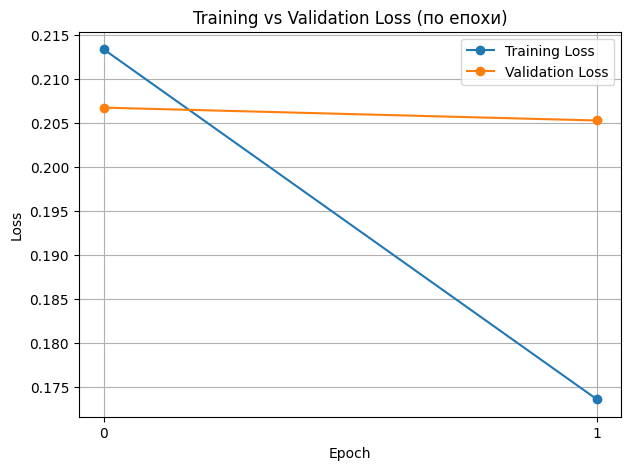

In [42]:
import matplotlib.pyplot as plt

logs = trainer.state.log_history

train_epoch_loss = []
val_epoch_loss = []

current_train_loss = None

for entry in logs:
    if "loss" in entry and "epoch" in entry:
        current_train_loss = entry["loss"]

    if "eval_loss" in entry:
        val_epoch_loss.append(entry["eval_loss"])
        train_epoch_loss.append(current_train_loss)

# График по епоха
plt.figure(figsize=(7,5))
plt.plot(train_epoch_loss, marker='o', label="Training Loss")
plt.plot(val_epoch_loss, marker='o', label="Validation Loss")
plt.title("Training vs Validation Loss (по епохи)")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.xticks(range(len(train_epoch_loss)))
plt.legend()
plt.grid(True)
plt.show()


Моделот константно ја намалува загубата на тренинг податоците, додека загубата на валидација останува стабилна и ниска. Ова укажува дека моделот добро генерализира и не се јавува overfitting.


In [44]:
save_path = "/content/drive/MyDrive/NLP/roberta_final"
trainer.save_model(save_path)
tokenizer.save_pretrained(save_path)
print(" Моделот е зачуван во:", save_path)


 Моделот е зачуван во: /content/drive/MyDrive/NLP/roberta_final


**DistilBERT**

In [55]:
# --- 1) Поставки и tokenizer ---
from transformers import AutoTokenizer
import torch
from torch.utils.data import Dataset
from tqdm.auto import tqdm

MAX_LEN = 128
tokenizer_d = AutoTokenizer.from_pretrained("distilbert-base-uncased", use_fast=True)

# --- 2) Encode функција (batch по batch за побрзо процесирање) ---
def encode_df_distilbert(df, batch_size=4000):
    all_ids, all_attn = [], []
    labels = torch.tensor(df["label"].values, dtype=torch.long)

    for i in tqdm(range(0, len(df), batch_size), desc="Encoding (DistilBERT)"):
        texts = df["text"].iloc[i : i+batch_size].astype(str).tolist()
        enc = tokenizer_d(
            texts,
            truncation=True,
            padding="max_length",
            max_length=MAX_LEN,
            return_tensors="pt"
        )
        all_ids.append(enc["input_ids"])
        all_attn.append(enc["attention_mask"])

    enc = {
        "input_ids": torch.cat(all_ids, dim=0),
        "attention_mask": torch.cat(all_attn, dim=0)
    }

    return enc, labels


# --- 3) Encode на dataset-ите ---
train_inputs_d, y_train_d = encode_df_distilbert(train_df)
val_inputs_d,   y_val_d   = encode_df_distilbert(val_df)
test_inputs_d,  y_test_d  = encode_df_distilbert(test_df)


# --- 4) PyTorch Dataset обвивка ---
class DistilDataset(Dataset):
    def __init__(self, inputs, labels):
        self.inputs = inputs
        self.labels = labels

    def __getitem__(self, i):
        return {
            "input_ids":      self.inputs["input_ids"][i],
            "attention_mask": self.inputs["attention_mask"][i],
            "labels":         self.labels[i],
        }

    def __len__(self):
        return len(self.labels)


# --- 5) Dataset за Trainer ---
train_ds_d = DistilDataset(train_inputs_d, y_train_d)
val_ds_d   = DistilDataset(val_inputs_d, y_val_d)
test_ds_d  = DistilDataset(test_inputs_d, y_test_d)


# Проверка
print("Train:", train_inputs_d["input_ids"].shape)
print("Val:  ", val_inputs_d["input_ids"].shape)
print("Test: ", test_inputs_d["input_ids"].shape)


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

Encoding (DistilBERT):   0%|          | 0/86 [00:00<?, ?it/s]

Encoding (DistilBERT):   0%|          | 0/11 [00:00<?, ?it/s]

Encoding (DistilBERT):   0%|          | 0/11 [00:00<?, ?it/s]

Train: torch.Size([342905, 128])
Val:   torch.Size([42863, 128])
Test:  torch.Size([42864, 128])


In [56]:
import os
os.environ["WANDB_DISABLED"]="true"; os.environ["WANDB_MODE"]="disabled"

from transformers import (DistilBertForSequenceClassification, TrainingArguments,
                          Trainer, DataCollatorWithPadding)

model_d = DistilBertForSequenceClassification.from_pretrained(
    "distilbert-base-uncased", num_labels=2
)

args_d = TrainingArguments(
    output_dir="distilbert_yelp_fast",
    learning_rate=3e-5,
    per_device_train_batch_size=64,
    per_device_eval_batch_size=128,
    num_train_epochs=2,
    weight_decay=0.01,
    fp16=True,
    eval_strategy="epoch",
    save_strategy="epoch",
    logging_steps=200,
    group_by_length=True,
    report_to="none",
    load_best_model_at_end=True,
)

collator_d = DataCollatorWithPadding(tokenizer_d, pad_to_multiple_of=8)

trainer_d = Trainer(
    model=model_d,
    args=args_d,
    train_dataset=train_ds_d,
    eval_dataset=val_ds_d,
    data_collator=collator_d,
)



model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [57]:
trainer_d.train()

Epoch,Training Loss,Validation Loss
1,0.233000,0.223933
2,0.182100,0.224346


TrainOutput(global_step=10716, training_loss=0.21555332017950532, metrics={'train_runtime': 2009.2528, 'train_samples_per_second': 341.326, 'train_steps_per_second': 5.333, 'total_flos': 2.271186666806784e+16, 'train_loss': 0.21555332017950532, 'epoch': 2.0})

In [58]:
# --- Evaluation на TEST сет со барани метрики ---
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import numpy as np

pred = trainer_d.predict(test_ds_d)

y_true = pred.label_ids
y_pred = np.argmax(pred.predictions, axis=1)

accuracy  = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred)
recall    = recall_score(y_true, y_pred)
f1        = f1_score(y_true, y_pred)

print("📊 DistilBERT Evaluation (TEST set):")
print(f"Accuracy:  {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall:    {recall:.4f}")
print(f"F1 Score:  {f1:.4f}")


📊 DistilBERT Evaluation (TEST set):
Accuracy:  0.9094
Precision: 0.9345
Recall:    0.9401
F1 Score:  0.9373


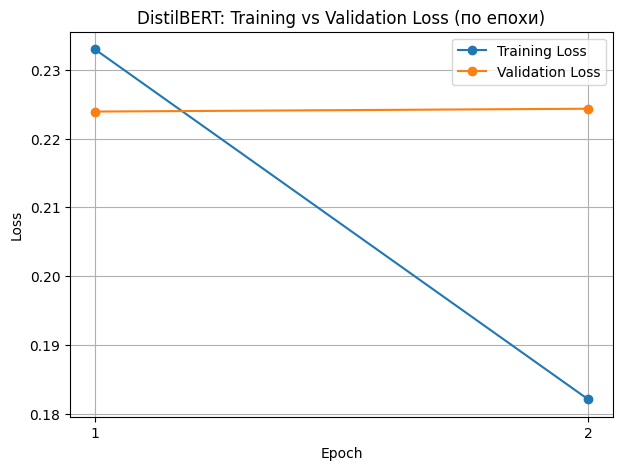

In [59]:
import matplotlib.pyplot as plt

logs = trainer_d.state.log_history

train_epoch_loss = []
val_epoch_loss = []
current_train_loss = None

for e in logs:
    if "loss" in e and "epoch" in e:
        current_train_loss = e["loss"]
    if "eval_loss" in e:
        val_epoch_loss.append(e["eval_loss"])
        train_epoch_loss.append(current_train_loss)

plt.figure(figsize=(7,5))
plt.plot(train_epoch_loss, marker='o', label="Training Loss")
plt.plot(val_epoch_loss, marker='o', label="Validation Loss")
plt.title("DistilBERT: Training vs Validation Loss (по епохи)")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.xticks(range(len(train_epoch_loss)), [f"{i+1}" for i in range(len(train_epoch_loss))])
plt.grid(True)
plt.legend()
plt.show()


DistilBERT претставува оптимален баланс помеѓу брзина и точност. Иако не ја достигнува максималната перформанса на RoBERTa, сепак обезбедува висока точност со многу пониски компјутерски трошоци и затоа е одличен избор за практични и продукциски решенија каде што е важна ефикасноста како во real-time апликации.

In [62]:
#  RoBERTa metrics
roberta_acc = 0.9238
roberta_prec = 0.9356
roberta_rec  = 0.9603
roberta_f1   = 0.9478


# DistilBERT metrics
distil_acc = 0.9094
distil_prec = 0.9345
distil_rec  = 0.9401
distil_f1   = 0.9373



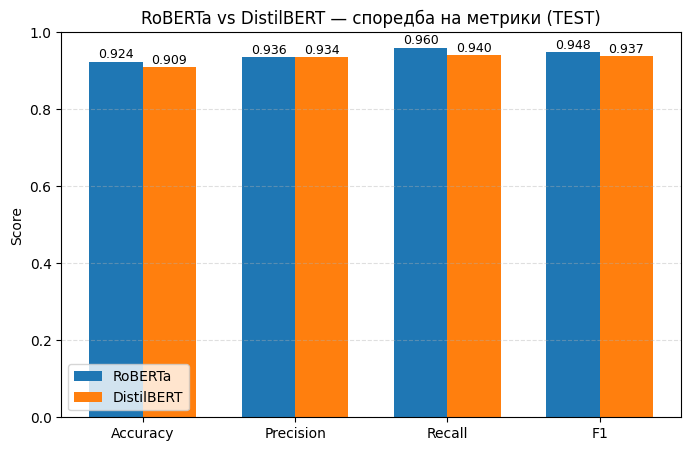

In [63]:
import numpy as np
import matplotlib.pyplot as plt

metrics = ["Accuracy", "Precision", "Recall", "F1"]
roberta_vals = [roberta_acc, roberta_prec, roberta_rec, roberta_f1]
distil_vals  = [distil_acc,  distil_prec,  distil_rec,  distil_f1]

x = np.arange(len(metrics))
w = 0.35

plt.figure(figsize=(8,5))
plt.bar(x - w/2, roberta_vals, width=w, label="RoBERTa")
plt.bar(x + w/2, distil_vals,  width=w, label="DistilBERT")

plt.xticks(x, metrics)
plt.ylim(0, 1.0)
for i, v in enumerate(roberta_vals):
    plt.text(i - w/2, v + 0.01, f"{v:.3f}", ha='center', fontsize=9)
for i, v in enumerate(distil_vals):
    plt.text(i + w/2, v + 0.01, f"{v:.3f}", ha='center', fontsize=9)

plt.title("RoBERTa vs DistilBERT — споредба на метрики (TEST)")
plt.ylabel("Score")
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.4)
plt.show()


In [64]:
import pandas as pd
df_cmp = pd.DataFrame({
    "Метрика": metrics,
    "RoBERTa": roberta_vals,
    "DistilBERT": distil_vals
})
print(df_cmp.to_string(index=False, formatters={"RoBERTa": "{:.4f}".format, "DistilBERT": "{:.4f}".format}))


  Метрика RoBERTa DistilBERT
 Accuracy  0.9238     0.9094
Precision  0.9356     0.9345
   Recall  0.9603     0.9401
       F1  0.9478     0.9373


Промената на хиперпараметрите директно влијае на тренингот: повеќе епохи ја намалуваат загубата, но водат до overfitting, додека соодветно избран learning rate овозможува стабилност и брза конвергенција. RoBERTa и DistilBERT покажуваат значително подобри резултати од класичните ML модели од Лаб. 1, бидејќи трансформерите го разбираат контекстот на текстот, а не само статистиката на зборови.

In [65]:
save_path = "/content/drive/MyDrive/NLP/distilbert_final"

trainer_d.save_model(save_path)
tokenizer_d.save_pretrained(save_path)

print(" DistilBERT моделот е успешно зачуван во:", save_path)


 DistilBERT моделот е успешно зачуван во: /content/drive/MyDrive/NLP/distilbert_final


In [66]:
!ls "/content/drive/MyDrive/NLP/distilbert_final"


config.json	   special_tokens_map.json  tokenizer.json     vocab.txt
model.safetensors  tokenizer_config.json    training_args.bin


#Задача 2

In [13]:
import pandas as pd


data = pd.read_csv("val_en.txt", sep="\t")
data


,Sentence,Style,User
0,A wee bit pricey for the portions they serve. ...,positive,ci7Q6NvXQ8UZrBHusVX18g
1,Cute lil spot on Germantown Ave. I came in cra...,positive,0rZEWmL2rccd-N5VMzKLiQ
2,They have great prices if you order family sty...,positive,3x69a8OGyReKirigOk8Nww
3,"Let's be honest, this place needs a face lift....",negative,7OUAzKZj6LUrQ3G7g7yUSw
4,Monthly lunch with my fellow colleagues the ot...,negative,zBWSORvlWDmwtcx6627qWQ
...,...,...,...
42858,My sister lived in this area as a teenager. I ...,positive,X4a1WSMYCfG6H46Fc34CUg
42859,Went here last Thursday with coworker who reco...,positive,6yMeRe_UQMfN1ukGRYhQsA
42860,Great bagels and cupcakes here for the vegan a...,positive,Vjb8dsOwTXQU-4bdmNzfbw
42861,I'll preface this review by saying I never eat...,positive,SVJvTooDYFA2OJn1vU_ofA


In [14]:
!pip install transformers torch --quiet


Zero-shot classification (T5)

In [18]:
import torch
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

tokenizer = AutoTokenizer.from_pretrained("google/flan-t5-small")
model = AutoModelForSeq2SeqLM.from_pretrained("google/flan-t5-small").to(DEVICE)

def predict_t5(text):
    prompt = f"Classify sentiment as positive or negative: {text}"
    inputs = tokenizer(prompt, return_tensors="pt", truncation=True, max_length=512).to(DEVICE)
    with torch.no_grad():
        out = model.generate(**inputs, max_new_tokens=3)
    pred = tokenizer.decode(out[0], skip_special_tokens=True).strip().lower()
    if "pos" in pred: return "positive"
    if "neg" in pred: return "negative"
    return pred

sample = data.sample(300, random_state=42)
y_true = sample["Style"].str.lower().values
y_pred = sample["Sentence"].apply(predict_t5).values

print("T5 ZERO-SHOT")
print("Acc:", accuracy_score(y_true, y_pred))
print("Prec:", precision_score(y_true, y_pred, pos_label="positive"))
print("Rec:", recall_score(y_true, y_pred, pos_label="positive"))
print("F1:", f1_score(y_true, y_pred, pos_label="positive"))

T5 ZERO-SHOT
Acc: 0.8933333333333333
Prec: 0.8936170212765957
Rec: 0.967741935483871
F1: 0.9292035398230089


 Zero-shot BART

In [19]:
from transformers import pipeline
from tqdm.auto import tqdm
import torch
import numpy as np

sample = data.sample(300, random_state=42).reset_index(drop=True)
texts  = sample["Sentence"].astype(str).str.slice(0, 512).tolist()  # крати на 512 знаци
y_true = sample["Style"].str.lower().values

# 2) BART zero-shot pipeline
device_idx = 0 if torch.cuda.is_available() else -1
clf = pipeline(
    "zero-shot-classification",
    model="facebook/bart-large-mnli",
    device=device_idx,
    truncation=True
)

labels = ["positive","negative"]
batch_size = 32   # намали на 16 ако е споро/OOM

# 3) Batch inference
preds = []
for i in tqdm(range(0, len(texts), batch_size)):
    batch = texts[i:i+batch_size]
    out = clf(
        batch,
        candidate_labels=labels,
        multi_label=False,
        hypothesis_template="The review is {}."  # едноставен template
    )
    preds.extend([o["labels"][0].lower() for o in out])

y_pred_b = np.array(preds)

# 4) Метрики
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report
print("\nBART ZERO-SHOT")
print("Acc:", accuracy_score(y_true, y_pred_b))
print("Prec:", precision_score(y_true, y_pred_b, pos_label="positive"))
print("Rec:", recall_score(y_true, y_pred_b, pos_label="positive"))
print("F1:", f1_score(y_true, y_pred_b, pos_label="positive"))
print("\nReport:\n", classification_report(y_true, y_pred_b, target_names=["negative","positive"]))


Device set to use cpu


  0%|          | 0/10 [00:00<?, ?it/s]


BART ZERO-SHOT
Acc: 0.8633333333333333
Prec: 0.8760683760683761
Rec: 0.9447004608294931
F1: 0.9090909090909091

Report:
               precision    recall  f1-score   support

    negative       0.82      0.65      0.72        83
    positive       0.88      0.94      0.91       217

    accuracy                           0.86       300
   macro avg       0.85      0.80      0.82       300
weighted avg       0.86      0.86      0.86       300



**Во zero-shot prompting, T5 постигна повисока точност и F1-мерка (Acc ≈ 0.89, F1 ≈ 0.93) во споредба со BART (Acc ≈ 0.86, F1 ≈ 0.91), што покажува дека T5 подобро го класифицира сентиментот без дополнително тренирање. BART има солидна прецизност, но T5 постигнува поконзистентни резултати и подобро ги препознава позитивните примери.**

#Few-shot prompt (ист за двата модели):
Example 1:

Text: The food was terrible and cold.

Sentiment: negative

Example 2:

Text: Amazing service and delicious meals.

Sentiment: positive

Decide if the sentiment is positive or negative.
Text: {REVIEW}
Sentiment:


Few-shot T5

In [21]:
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM
import torch
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

tokenizer = AutoTokenizer.from_pretrained("google/flan-t5-base")
model = AutoModelForSeq2SeqLM.from_pretrained("google/flan-t5-base").to(DEVICE)

few_shot_prompt = """
Example 1:
Text: The food was terrible and cold.
Sentiment: negative

Example 2:
Text: Amazing service and delicious meals.
Sentiment: positive

Decide if the sentiment is positive or negative.
Text: {sentence}
Sentiment:
"""

def predict_t5_fewshot(text):
    prompt = few_shot_prompt.format(sentence=text)
    inputs = tokenizer(prompt, return_tensors="pt", truncation=True, max_length=512).to(DEVICE)
    with torch.no_grad():
        output = model.generate(**inputs, max_new_tokens=3)
    prediction = tokenizer.decode(output[0], skip_special_tokens=True).strip().lower()

    if "pos" in prediction: return "positive"
    if "neg" in prediction: return "negative"
    return prediction

# predict on the SAME 300 samples
y_pred_t5_fs = sample["Sentence"].apply(predict_t5_fewshot).values
y_true = sample["Style"].str.lower().values

print("\nT5 FEW-SHOT RESULTS")
print("Acc:", accuracy_score(y_true, y_pred_t5_fs))
print("Prec:", precision_score(y_true, y_pred_t5_fs, pos_label="positive"))
print("Rec:", recall_score(y_true, y_pred_t5_fs, pos_label="positive"))
print("F1:", f1_score(y_true, y_pred_t5_fs, pos_label="positive"))



T5 FEW-SHOT RESULTS
Acc: 0.8966666666666666
Prec: 0.8974358974358975
Rec: 0.967741935483871
F1: 0.9312638580931264


Few-shot BART

In [22]:
from transformers import pipeline
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report
from tqdm.auto import tqdm
import torch
import numpy as np

# --- SETTINGS ---
source = sample.reset_index(drop=True)      # истите 300 примероци (sample(300))
few_shot = True                             # True = few-shot
truncate_len = 256
labels = ["positive", "negative"]
batch_size = 32
# ----------------

# truncate текстови
texts = source["Sentence"].astype(str).str.slice(0, truncate_len).tolist()
y_true = source["Style"].str.lower().values

# Few-shot prompt (ист како кај T5)
few_shot_template = """
Example 1:
Text: The food was terrible and cold.
Sentiment: negative

Example 2:
Text: Amazing service and delicious meals.
Sentiment: positive

Decide if the sentiment is positive or negative.
Text: {}
Sentiment:
"""

def build_input(t):
    if few_shot:
        return few_shot_template.format(t)
    return t

# Zero-shot classifier
device_idx = 0 if torch.cuda.is_available() else -1
clf = pipeline(
    "zero-shot-classification",
    model="facebook/bart-large-mnli",
    device=device_idx,
    truncation=True
)

# inference
preds = []
for i in tqdm(range(0, len(texts), batch_size)):
    batch = texts[i:i + batch_size]
    batch_inputs = [build_input(t) for t in batch]

    out = clf(batch_inputs, candidate_labels=labels, multi_label=False)
    preds.extend([o["labels"][0].lower() for o in out])

y_pred = np.array(preds)

# metrics
print("\n BART FEW-SHOT RESULTS")
print("Acc:", accuracy_score(y_true, y_pred))
print("Prec:", precision_score(y_true, y_pred, pos_label="positive"))
print("Rec:", recall_score(y_true, y_pred, pos_label="positive"))
print("F1:", f1_score(y_true, y_pred, pos_label="positive"))
print("\nReport:\n", classification_report(y_true, y_pred, target_names=["negative","positive"]))


Device set to use cpu


  0%|          | 0/10 [00:00<?, ?it/s]


 BART FEW-SHOT RESULTS
Acc: 0.41
Prec: 0.8571428571428571
Rec: 0.22119815668202766
F1: 0.3516483516483517

Report:
               precision    recall  f1-score   support

    negative       0.31      0.90      0.46        83
    positive       0.86      0.22      0.35       217

    accuracy                           0.41       300
   macro avg       0.58      0.56      0.41       300
weighted avg       0.71      0.41      0.38       300



Во Few-shot prompting, T5 значително го подобри резултатот и постигна највисока точност и F1-мерка, што покажува дека успешно користи дадени примери во prompt-от. Наспроти тоа, перформансите на BART драматично се влошија при few-shot prompting, затоа што моделот не е обучен за instruction/few-shot сценарија и не ги искористува примерите во prompt-от. Како заклучок, T5 е далеку поефективен за Few-shot prompting во споредба со BART.

Во втората задача ги применивме моделите T5 и BART со техниките zero-shot и few-shot prompting за класификација на сентимент врз Yelp датасет. Резултатите покажаа дека FLAN-T5 има најдобра перформанса, особено во few-shot prompting, каде што постигна највисока точност и F1-мерка. BART покажа добри резултати во zero-shot, но неговите перформанси драстично се влошија кај few-shot prompting, затоа што моделот не е instruction-tuned и не ги користи примерите од prompt-от.

Во споредба со моделите од првата лабораториска вежба (класични ML модели) и моделите од претходната задача (LSTM со Word2Vec), T5 постигна повисоки метрики без да се тренира на датасетот, што ја демонстрира моќта на Large Language Models кога се користат со prompting. Сепак, ML и LSTM моделите имаат предност во стабилност и конзистентност, бидејќи се прилагодуваат на специфичниот датасет преку тренинг.